C:\Users\xiato\AppData\Local\Temp\ipykernel_72048\252771380.py:246: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["low_flu_month"] = df["low_flu_month"].fillna(False)


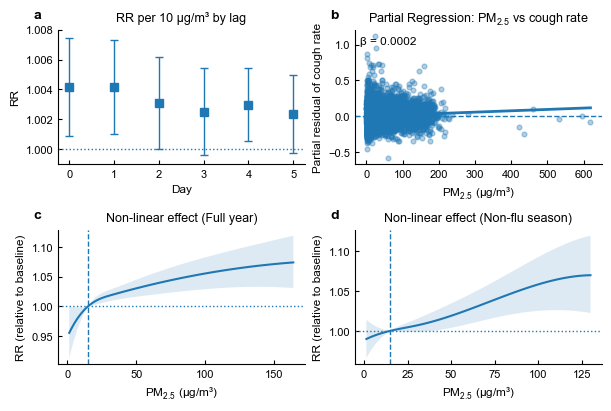

In [1]:
# -*- coding: utf-8 -*-
# === Four-panel "Nature-like" figure (a/b/c/d) ===

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
from patsy import dmatrix, build_design_matrices
import statsmodels.api as sm

# =========================
# Global style (Nature-like)
# =========================
FIG_W, FIG_H = 6,4  # approx. two-column width in inches

mpl.rcParams.update({
    "font.size": 8.5,
    "axes.titlesize": 9.0,
    "axes.labelsize": 8.5,
    "xtick.labelsize": 8.0,
    "ytick.labelsize": 8.0,
    "legend.fontsize": 8.0,
    "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans"],
    "mathtext.default": "regular",
    "axes.linewidth": 0.8,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
})

def style_axes(ax, xlabel=None, ylabel=None, title=None, top_right_off=True):
    if top_right_off:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.8)
    ax.spines["bottom"].set_linewidth(0.8)
    ax.tick_params(axis="both", which="both", width=0.8, length=3)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    if title:  ax.set_title(title, pad=6)

def panel_label(ax, letter):
    ax.text(-0.1, 1.15, letter, transform=ax.transAxes,
            va="top", ha="left", fontsize=10, fontweight="bold")

# =========================
# 读入与清洗（与你原始代码一致）
# =========================
df_panel = pd.read_csv('panel_data_all_with_flu_rate.csv')
df_merged = pd.read_csv('df_merged.csv')

df_merged = df_merged[df_merged['user_rate'] > 0.5].reset_index(drop=True)
ciyt_list = df_merged['Country-city'].tolist()

df_panel['pm25'] = pd.to_numeric(df_panel['pm25'], errors='coerce')
df_panel['cough_rate'] = pd.to_numeric(df_panel['cough_rate'], errors='coerce')
df_panel = df_panel.dropna(subset=['cough_rate', 'pm25', 'city', 'country'])

df_panel['date'] = pd.to_datetime(df_panel['date'], errors='coerce')
df_panel = df_panel[~((df_panel['date'] >= "2024-04-20") & (df_panel['date'] <= "2024-04-23"))]
df_panel['label'] = df_panel['country'] + '-' + df_panel['city']

cities = df_panel['label'].tolist()
ciyt_list = sorted(list(set(ciyt_list) & set(cities)))
df_panel = df_panel[df_panel['label'].isin(ciyt_list)].copy()

# =========================
# 公用参数 & 函数
# =========================
DELTA = 10                 # RR per 10 μg/m³
LAGS = list(range(0, 6))   # 0~5
CONTROL_VARS = ["flu_rate", "TAVG", "PRCP"]

def estimate_rr_by_lag(df_panel, lags=LAGS, delta=DELTA, controls=CONTROL_VARS):
    """Run log(cough) ~ pm25_lag + controls + FE (entity+time), return RR table for forest plot."""
    df = df_panel.copy()
    for c in ["pm25", "TAVG", "PRCP", "flu_rate", "cough_rate"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df[(df["cough_rate"].notna()) & (df["cough_rate"] > 0)].copy()
    df["cough_rate_log"] = np.log(df["cough_rate"])

    df = df.set_index(["city", "date"]).sort_index()

    # generate lags
    for k in lags[1:]:
        df[f"pm25_l{k}"] = df.groupby(level="city")["pm25"].shift(k)

    rows = []
    for k in lags:
        lag_var = "pm25" if k == 0 else f"pm25_l{k}"
        exog_vars = [lag_var] + controls

        use = df.dropna(subset=exog_vars + ["cough_rate_log"])
        if use.empty or use[lag_var].var() == 0:
            continue

        X = use[exog_vars]
        y = use["cough_rate_log"]

        mod = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
        res = mod.fit(cov_type="clustered", cluster_entity=True, cluster_time=True)

        if lag_var in res.params.index:
            beta = res.params[lag_var]
            se   = res.std_errors[lag_var]
            rr       = np.exp(beta * delta)
            rr_low   = np.exp((beta - 1.96 * se) * delta)
            rr_high  = np.exp((beta + 1.96 * se) * delta)

            rows.append({
                "lag": k, "RR": rr, "CI_low": rr_low, "CI_high": rr_high,
                "beta": beta, "se": se, "n_obs": int(res.nobs),
            })

    df_plot = pd.DataFrame(rows).sort_values("lag").reset_index(drop=True)
    return df_plot

def plot_forest_style(ax, df_plot, title=r"PM$_{2.5}$", xlabels=None, y_label="RR",
                      y_min=None, y_max=None):
    """Square markers + vertical CI; dashed y=1 line."""
    if df_plot.empty:
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center", va="center")
        return

    if xlabels is None:
        xlabels = [f"{i}" for i in df_plot["lag"]]

    x = np.arange(len(df_plot))
    y = df_plot["RR"].values
    yerr = np.vstack([y - df_plot["CI_low"].values,
                      df_plot["CI_high"].values - y])

    # markersize / caps etc. kept subtle
    ax.errorbar(x, y, yerr=yerr, fmt="s", markersize=6, capsize=3, elinewidth=1, lw=0)
    ax.axhline(1.0, linestyle=":", linewidth=1)

    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    style_axes(ax, xlabel="Day", ylabel=y_label, title=title)
    if (y_min is not None) and (y_max is not None):
        ax.set_ylim(y_min, y_max)

def _normalize_panel(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    确保 'city' 与 'date' 是普通列（不是索引），且 'date' 为 datetime64。
    避免因重复 set_index 触发的 'cannot insert date, already exists'。
    """
    df = df_in.copy()

    # 若已经是 MultiIndex 或 Index 中包含 city/date，则全部还原为列
    if isinstance(df.index, pd.MultiIndex):
        if set(["city", "date"]).issubset(set(df.index.names)):
            df = df.reset_index()
        else:
            # 即使不是这两个名字，也统一 reset，避免后续 set_index 冲突
            df = df.reset_index()
    else:
        # 单层索引名刚好叫 'date' 或 'city' 的情况
        if df.index.name in ("city", "date"):
            df = df.reset_index()

    # 保证存在这些列
    if "date" not in df.columns:
        raise ValueError("Input dataframe lacks 'date' column after normalization.")
    if "city" not in df.columns:
        raise ValueError("Input dataframe lacks 'city' column after normalization.")

    # 强制 date 为 datetime64[ns]
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    return df

def build_panel_and_fit_linear(df_panel):
    """
    线性 FE：用于面板 b 的部分残差图
    """
    df = _normalize_panel(df_panel)

    # ensure numeric
    for c in ["pm25", "TAVG", "PRCP", "flu_rate", "cough_rate"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # cough_rate 这里你画的是「cough rate」（非 log），与原代码一致
    df = df.dropna(subset=["pm25", "flu_rate", "TAVG", "PRCP", "cough_rate"]).copy()

    # 设面板索引（此时不会再报重复）
    df = df.set_index(["city", "date"]).sort_index()

    X = df[["pm25", "flu_rate", "TAVG", "PRCP"]]
    y = df["cough_rate"]

    mod = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
    res = mod.fit(cov_type="clustered", cluster_entity=True, cluster_time=True)
    return df, res

def draw_partial_regression(ax, df, res, x_label=r"PM$_{2.5}$ (μg/m³)",
                            y_label="Partial residual of cough rate",
                            title="Partial Regression Plot: PM$_{2.5}$ and cough rate"):
    beta_pm25 = res.params["pm25"]
    idx = res.resids.index
    x = df.loc[idx, "pm25"]
    partial_residual = beta_pm25 * x + res.resids

    ax.scatter(x, partial_residual, alpha=0.35, s=12)
    X_line = sm.add_constant(x.to_numpy())
    fit_line = sm.OLS(partial_residual.to_numpy(), X_line).fit()
    xs = np.linspace(x.min(), x.max(), 200)
    ys = fit_line.params[0] + fit_line.params[1] * xs
    ax.plot(xs, ys, linewidth=2)
    ax.axhline(0, linestyle="--", linewidth=1)

    style_axes(ax, xlabel=x_label, ylabel=y_label, title=title)
    # slope annotation (optional, compact)
    txt = f"β = {beta_pm25:.4f}"
    ax.text(0.02, 0.95, txt, transform=ax.transAxes, va="top")

def fit_spline_fe(df_panel, subset_low_flu=False):
    """
    样条 + 两向 FE + 双聚类；可选：限定低流感月份
    """
    df = _normalize_panel(df_panel)

    # 基础清洗
    for c in ["pm25", "TAVG", "PRCP", "flu_rate", "cough_rate"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # （可选）提前构造 year/month（后面 subset_low_flu 要用）
    df["year"]  = df["date"].dt.year
    df["month"] = df["date"].dt.month

    if subset_low_flu:
        # 计算国家-年月的 influenza 月均，并挑选低流感月份
        monthly_avg = (
            df.groupby(["country", "year", "month"])["flu_rate"]
              .mean()
              .reset_index(name="flu_rate_month")
        )
        low_flu = monthly_avg[monthly_avg["flu_rate_month"] < 0.1][["country", "year", "month"]]
        # 右连接标记
        df = df.merge(low_flu.assign(low_flu_month=True),
                      on=["country", "year", "month"], how="left")
        df["low_flu_month"] = df["low_flu_month"].fillna(False)
        df = df[df["low_flu_month"]].copy()

    # 需要 log(cough_rate)
    df = df[(df["cough_rate"].notna()) & (df["cough_rate"] > 0)].copy()
    df["cough_rate_log"] = np.log(df["cough_rate"])

    # 设索引（此时确保 date 是列，不会冲突）
    df = df.set_index(["city", "date"]).sort_index()

    # 样条基（无截距，避免与 FE 冲突）
    pm25_spline = dmatrix("bs(pm25, df=4, include_intercept=False)",
                          data=df, return_type="dataframe")
    pm25_spline.columns = [f"pm25_spline_{i+1}" for i in range(pm25_spline.shape[1])]
    df = pd.concat([df, pm25_spline], axis=1)

    exog_vars = pm25_spline.columns.tolist() + ["flu_rate", "TAVG", "PRCP"]
    use = df.dropna(subset=exog_vars + ["cough_rate_log"]).copy()

    X = use[exog_vars]
    y = use["cough_rate_log"]

    mod = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
    res = mod.fit(cov_type="clustered", cluster_entity=True, cluster_time=True)

    # 预测网格
    p1, p99 = np.nanpercentile(use["pm25"], [1, 99])
    pm25_grid = np.linspace(p1, p99, 120)

    # 与训练完全一致的设计矩阵
    pred_design = build_design_matrices(
        [pm25_spline.design_info], pd.DataFrame({"pm25": pm25_grid})
    )[0]
    pred_design = pd.DataFrame(pred_design, columns=pm25_spline.columns)

    spline_cols = [c for c in res.params.index if c.startswith("pm25_spline_")]
    beta_spline = res.params[spline_cols].values
    cov_spline  = res.cov.loc[spline_cols, spline_cols].values

    pm25_baseline = 15  # 你原来的基线
    base_design = build_design_matrices(
        [pm25_spline.design_info], pd.DataFrame({"pm25": [pm25_baseline]})
    )[0]
    base_design = np.asarray(base_design).reshape(1, -1)

    A = pred_design.values
    a0 = base_design
    A_diff = A - a0

    log_rr = A_diff @ beta_spline
    var_log_rr = np.einsum('ij,jk,ik->i', A_diff, cov_spline, A_diff)
    se_log_rr = np.sqrt(np.maximum(var_log_rr, 0))

    RR      = np.exp(log_rr)
    RR_low  = np.exp(log_rr - 1.96 * se_log_rr)
    RR_high = np.exp(log_rr + 1.96 * se_log_rr)

    return pm25_grid, RR, RR_low, RR_high, pm25_baseline

def draw_spline_rr(ax, pm25_grid, RR, RR_low, RR_high, pm25_baseline,
                   title="Non-linear effect of PM$_{2.5}$ on cough rate",
                   x_label=r"PM$_{2.5}$ (μg/m³)", y_label="RR (relative to baseline)"):
    ax.plot(pm25_grid, RR)
    ax.fill_between(pm25_grid, RR_low, RR_high, alpha=0.15)
    ax.axhline(1.0, linestyle=":", linewidth=1)
    ax.axvline(pm25_baseline, linestyle="--", linewidth=1)
    style_axes(ax, xlabel=x_label, ylabel=y_label, title=title)

# =========================
# 计算 & 作图
# =========================
# Panel a: Forest-style RR by lag
df_plot = estimate_rr_by_lag(df_panel, lags=LAGS, delta=DELTA, controls=CONTROL_VARS)
xlabels_hours = [f"{i}" for i in df_plot["lag"]]  # 你也可以换成 ["0-6","6-12",...] 等

# Panel b: Partial regression (linear) with FE
df_lin, res_lin = build_panel_and_fit_linear(df_panel)

# Panel c: Non-linear (full year)
grid_full, RR_full, RR_full_low, RR_full_high, baseline_full = fit_spline_fe(df_panel, subset_low_flu=False)

# Panel d: Non-linear (low-flu months)
grid_low, RR_low, RR_low_low, RR_low_high, baseline_low = fit_spline_fe(df_panel, subset_low_flu=True)

# ========== Figure (2×2) ==========
fig, axes = plt.subplots(2, 2, figsize=(FIG_W, FIG_H), constrained_layout=True)
(ax_a, ax_b), (ax_c, ax_d) = axes

# a
panel_label(ax_a, "a")
plot_forest_style(ax_a, df_plot,
                  title=r"RR per 10 μg/m³ by lag",
                  xlabels=xlabels_hours, y_label="RR",
                  # 你之前固定了 [0.999, 1.008]，也可注释掉让其自适应：
                  y_min=0.999, y_max=1.008)

# b
panel_label(ax_b, "b")
draw_partial_regression(ax_b, df_lin, res_lin,
                        x_label=r"PM$_{2.5}$ (μg/m³)",
                        y_label="Partial residual of cough rate",
                        title="Partial Regression: PM$_{2.5}$ vs cough rate")

# c
panel_label(ax_c, "c")
draw_spline_rr(ax_c, grid_full, RR_full, RR_full_low, RR_full_high, baseline_full,
               title="Non-linear effect (Full year)",
               x_label=r"PM$_{2.5}$ (μg/m³)",
               y_label="RR (relative to baseline)")

# d
panel_label(ax_d, "d")
draw_spline_rr(ax_d, grid_low, RR_low, RR_low_low, RR_low_high, baseline_low,
               title="Non-linear effect (Non-flu season)",
               x_label=r"PM$_{2.5}$ (μg/m³)",
               y_label="RR (relative to baseline)")

# 导出
plt.savefig("figure3_2x2.pdf")
plt.show()
